
# Setup

Lattice: MxM matrix with entries $N_i$
Update rule for $N_i$: $N_i^{(t+1)} = N_i^{t} + r N_i^{t}(1 - \frac{N_i^{t}}{P_i}) \Delta t$
Parameters: $r, \Delta t$

$P_i$ is the productivity and depends on the "match" between Environment $E_i$ and Population skills $G_i$. Both are binary vectors.
We have $P_i = P_0 < E_i, G_i >$.

If population is too large it gets split: $p_s = \alpha (N_i - N_0)$ with $N_0 = 100$ and $\alpha = 1 / 400$

For the basic variant, we observe a sigmoid (solution of the logistic equation). The "squishing" depends on the productivity, and the initial population level as expected.

Do we really want a binary vector? Spatial correlation might be difficult to achieve, and is perhaps unrealistic. Probably not. Just normalize the thing in the end.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import noise
from tqdm import tqdm
import logging
import cProfile
import pstats

In [2]:
# Helper funcs
def remove_all_indices(arr, target_index):
    """Remove indices that match target_index from array. OUTDATED"""
    mask = np.any(arr != target_index, axis=1)
    return arr[mask]

def remove_entry_from_list(from_list, target):
    """Removes ALL entries that are equal to target from a custom (nested) list"""
    if not isinstance(target, tuple):
        raise TypeError("Tuple needed")
    return [idx for idx in from_list if idx != target]

def flip_entries(array, p_flip=0.01):
    """ Flip values of a binary array with probability p_flip."""
    random_numbers = np.random.random(size=array.shape) # Generate floats in interval [0, 1)
    flip = random_numbers < p_flip
    return np.logical_xor(array, flip).astype(int) # Convert boolean to integer

def calculate_productivity(skill_arr, env_arr, prod_scaling=1, min_prod=0, dimension="1d"):
    """ Calculates the productivity according to prod_scale * <S_i, E_i>.
    If skill_arr and env_arr are array_like with dimension > 1, calculate dot product along the last axis.
    Else, return dot product directly.
    The return value is multiplied with prod_scaling and clipped to clip_min if not None
    """
    if len(skill_arr.shape) == 1: # 1D array
        arr = np.dot(skill_arr, env_arr)

    elif len(skill_arr.shape) == 2: # 2D array
        arr = np.einsum("ij, ij -> i", skill_arr, env_arr)

    elif len(skill_arr.shape) == 3: # 3D array
        arr = np.einsum("ijk, ijk -> ij", skill_arr, env_arr)

    else:
        raise TypeError("Only implemented for 1-3D arrays")

    arr *= (prod_scaling / skill_arr.shape[-1]) # scale and normalize
    if min_prod > 0:
        np.clip(arr, min_prod, None, out=arr) # clip to minimal value

    assert not np.any(np.isnan(arr)), "Productivity array contains NaNs"
    assert not np.any(np.isinf(arr)), "Productivity array contains +/- infinity"

    return arr

def set_neighborhood(distance=1, neigh_type="moore"):
    """
    General: Return possible neighbor candidates for a cell at location "cell_location".
    Variables to consider are radius (for a network), or type of neighborhood + distance of neighborhood (for lattice)
    For now we only consider a lattice.

    The current idea is to avoid a for loop here, i.e. we want to find a list of indices that we can slice the array with.
    The problem is that the indices possibly overlap, and we can't slice the array twice. Other, we have a solution using np.newaxis and numpy broadcasting magic.
    So it probably *is* better to use a for loop for now.

    Specific: Return the indices for a von-Neumann (taxicab metric) or Moore (incl. diagonals) neighborhood.
    The output of this function (x and y indices) are to be added to the desired point. Only used once and then stored.
    This returns a transposed index array which might not be ideal. Fix.
    """
    idx_range = np.arange(-distance, distance + 1) # assumes centered point
    r_indices, c_indices = np.meshgrid(idx_range, idx_range, indexing="ij") # use ij convention

    r_indices = r_indices.ravel() # flatten
    c_indices = c_indices.ravel()

    ele_center = distance * (2 * distance + 2) # an array of length N has its center at (N-1) // 2 -> 2D center at (N-1) / 2 x (N + 1)
    r_indices = np.delete(r_indices, ele_center) # delete center element
    c_indices = np.delete(c_indices, ele_center)

    if neigh_type == "moore":
        return r_indices, c_indices

    elif neigh_type == "von_neumann":
        to_keep = []
        for idx, (rr, cc) in enumerate(zip(r_indices, c_indices)):
            if (np.abs(rr) + np.abs(cc)) <= distance:
                to_keep.append(idx)

        return r_indices[to_keep], c_indices[to_keep]

    else:
        raise NotImplementedError("Valid methods names are moore and von_neumann.")

In [3]:
class Lattice:
    """Base object for population dynamics in medieval Europe. Square lattice.
    Central object is a square lattice with shape (time, x, x) which keeps the track of the population in each village.
    """

    def __init__(self, size=10, steps_sim=5_000, seed=50, idx_start=(0, 0), num_env_vars=10,
                 pop_min=100, pop_max=500, rate_growth=1/30, prod_min=1, rate_prod=200):
        """ Initializes lattice object with shape (time=steps_sim, size, size). assumes that env. vector
        and skill vector have the same length. Also initializes environment and skill vectors to calculate productivity.
        Current data type of population array is float (integer messes up the update rule)
        """
        self.rng = np.random.default_rng(seed=seed) # initialize RNG
        self.r0, self.c0 = idx_start # location of first settlement
        self.size = size # 1d size of square lattice
        self.shape = (steps_sim, size, size) # only square lattice - time is 0 axis
        self.population = np.zeros(self.shape)
        self.population[0, self.r0, self.c0] = 10 # 10 people initially

        self.num_env_vars = num_env_vars
        self.num_skill_vars = num_env_vars # assume same length for environment and skill vectors
        self.pop_min, self.pop_max = pop_min, pop_max # min / max population for a village to split (i.e. split with p=1 above max)

        self.rate_growth = rate_growth # set growth of population rate
        self.env = self.init_env_perlin(scale=0.2) # perlin env with scale 0.2 for now
        self.rate_prod = rate_prod # If this is large, small changes in the productivity are amplified

        # Deal with negative population growth:
        thresh = self.pop_max / (2 * (1 + 1 / self.rate_growth))
        self.prod_min = prod_min
        assert prod_min >= 0 and isinstance(prod_min, int), "Provide minimum productivity as positive integer"
        if prod_min <= thresh:
            logging.warning("Negative population growth might overshoot. Population gets clipped to zero.")
            self.clip_population_to_zero = True
        else:
            self.clip_population_to_zero = False

        # initialize skills - assign random bin. vector with length (num_skill_vars) to starting village
        self.skills = np.zeros((size, size, self.num_skill_vars))
        self.skills[self.r0, self.c0] = self.rng.integers(size=self.num_skill_vars, low=0, high=1, endpoint=True)
        self.prod = np.zeros((size, size))
        self.prod = calculate_productivity(self.skills, self.env, prod_scaling=self.rate_prod, min_prod=self.prod_min)

        self.num_iter = 1
        self.has_valid_neighbors = np.ones((size, size)) # whether a village has empty neighbors
        self.has_valid_neighbors = self.has_valid_neighbors > 0 # in the beginning all cells have empty neighbors

        self.is_empty = np.zeros((size, size)) # whether a village is empty
        self.is_empty[self.r0, self.c0] = 1 # all villages except starting loc are empty
        self.is_empty = self.is_empty == 0 # or .astype(bool)

        self.indices_r, self.indices_c = [], [] # indices to select neighbors
        self.prod_threshold = 0 # If productivity is below this threshold, villagers stay idle. Init. equal to min. productivity.
        self.search_intelligently = False # If True, select cells probabilistically based on productivity

        self.env_mutation_rate = None # Probability that one entry of the environment vector per site flips
        self.skill_mutation_rate = None # Same but for skills
        self.skill_mutates_randomly = True # If skills mutate randomly or a more elaborate scheme is used (e.g. metropolis)

        # TODO: Should be always set to True - and no minimum productivity - only thing is that then cells die immediately
        # I.E. maybe delete attribute minimum productivity at all
        self.repopulate_empty_cells = False # Repopulate dead villages - don't if no mutations for skill and env.
        self.metropolis_scale = 1 # scaling factor for metropolis algorithm

        self.prod_full = np.empty(self.shape) # Array to keep track of the productivity

    def init_env_perlin(self, scale=0.1):
        """Create an environment of shape (size, size, num_entries) with Perlin noise.
        This yields spatially correlated noise. scale gives the correlation length"""
        # Populate environment with spatially correlated variables
        env_perlin = np.zeros((self.size, self.size, self.num_env_vars))
        for ii in range(M):
            for jj in range(M):
                env_perlin[ii, jj] = [noise.pnoise3(ii * scale, jj * scale, k * scale) for k in range(self.num_env_vars)]

        # Binarize the array
        for ii in range(self.num_env_vars):
            env_perlin[:, :, ii] = np.where(env_perlin[:, :, ii] > 0, 1, 0)

        return env_perlin

    def get_split_probs(self, population):
        """ Calculate the probability that each village splits. Uses uniform cdf."""
        factor = 1 / (self.pop_max - self.pop_min)
        raw = factor * (population - self.pop_min)
        return np.clip(raw, 0, 1)

    def update_population(self, pop_current):
        """Updates the population according to discrete solution of logistic ODE.
        If prod << 1, then the population will turn negative if non-zero (as e.g. after a split).
        To avoid this, we clip the population to zero.
        To avoid division by zero error, we add an epsilon to the divisor.
        Alternatively, we can clip to e.g. -100 to distinguish "dead" from empty villages.
        NB: np.divide(x, 0) with x > 0 returns np.inf. np.divide(0, 0) returns np.nan
        (happens e.g. if population and productivity are both zero)
        Problem: If cell has been populated, but the productivity is zero, then the population will go to zero
        and in the NEXT iteration we will again have NAN. To avoid that, we check is_empty attribute
        """
        with np.errstate(divide="ignore", invalid="ignore"):
            pop_new = pop_current + self.rate_growth * pop_current * (1 - np.divide(pop_current, self.prod))
        assert pop_new.dtype == self.population.dtype

        if np.any(pop_new - pop_current < 1) and np.issubdtype(lattice.population.dtype, np.integer):
            logging.warning("In meth. update_population: Increase in population of one village is less than unity.")

        if self.clip_population_to_zero:
            np.clip(pop_new, 0, None, out=pop_new)
            mask = np.isnan(pop_new) & np.logical_not(self.is_empty) # check if village has been occupied and is NaN
            pop_new[mask] = 0

        # These checks are for safety - add way to run this in verbose mode?
        if np.any(pop_new < 0):
            raise ValueError("Population is negative. Either increase minimum productivity or set it to None to"
                             "clip array")

        if np.any(np.isnan(pop_new) & np.logical_not(self.is_empty)):
            raise ValueError("A village that has been populated has a population of NAN instead of zero")

        return pop_new

    def set_search_params(self, prod_threshold=100, neigh_type="von_neumann", distance=1, search_intelligently=False):
        """ Sets the type of search environment. For now: Lattice with Moore and VN neighborhoods.
        If the productivity of the selected cell is below prod_threshold, the cell doesn't split.
        distance attribute sets the size of the neighborhoods (e.g. distance 1 for Moore is 3x3)
        """
        self.indices_r, self.indices_c = set_neighborhood(distance=distance, neigh_type=neigh_type)
        self.prod_threshold = prod_threshold
        self.search_intelligently = search_intelligently

    def set_evolution_params(self, env_mutation_rate=None, skill_mutation_rate=None, skill_mutates_randomly=True,
                             metropolis_scale=1, repopulate_empty_cells=False):
        """Sets / updates parameters for evolution, e.g. environment / skill mutation rate or prod. scaling factor.
        For now, only updates the mutation rates."""
        self.env_mutation_rate = env_mutation_rate # environment mutation rate
        self.skill_mutation_rate = skill_mutation_rate # skill mutation rate
        self.skill_mutates_randomly = skill_mutates_randomly # mutate directionally (metropolis) or random
        self.metropolis_scale = metropolis_scale # scaling ratio for Metropolis
        self.repopulate_empty_cells = repopulate_empty_cells # repopulate dead villages

        # Checks
        if env_mutation_rate is None and skill_mutation_rate is None and self.repopulate_empty_cells:
                logging.warning("If neither the environment nor the skill mutates, it is "
                                "strongly advised to set repopulate_empty_cells to False to speed up the code.")

        if self.clip_population_to_zero and not self.repopulate_empty_cells:
            logging.warning("Villages can die (zero population) but cannot be re-populated.")

    def mutate_skill_metropolis(self, p_flip, mask_additional=None, scale=1):
        """Metropolis-like mutation for skills. Compares the ratio alpha = Prod(flip) / prod_previous and accepts the proposed
        flip if alpha = num where num is a uniform float in [0, 1]
        If scale != 1, the ratio array gets exponentiated by scale, e.g. ratio -> ratio ** scale
        This exacerbates larger differences, e.g. 0.75 -> 0.56 (scale = 2) -> 0.42
        """
        prod_previous = calculate_productivity(self.skills, self.env, prod_scaling=self.rate_prod, min_prod=self.prod_min)

        skills_update = self.flip_single_entry_per_cell(self.skills, p_flip=p_flip, mask_additional=mask_additional)

        prod_update = calculate_productivity(skills_update, self.env, prod_scaling=self.rate_prod, min_prod=self.prod_min)
        with np.errstate(divide="ignore", invalid="ignore"): # ignore division by zero warning
            ratio = np.divide(prod_update, prod_previous)

        ratio = np.power(ratio, scale) # apply custom scaling

        nums = self.rng.uniform(low=0, high=1., size=(self.size, self.size))
        accept_flip = ratio > nums # accept flip dep. on ratio

        self.skills[accept_flip] = skills_update[accept_flip]

        return self.skills

    def has_valid_neighbors(self, candidates_r, candidates_c):
        """Similar to get_neighbors, but with different functionality. Function (vectorized) to check if a cell has valid neighbors.
        As of today, valid neighbors are A) empty B) above the minimum productivity and C) within the lattice.
        Why is this function used? Assume all villages are above pop_max. Then all villages split. Then the for loop in move_forward
        has complexity O(N^2), and is called in each iteration. We prune this for-loop using this function.

        NB: This functions was fun to code for some insights to numpy arrays, but is slow and needs rework
        """
        logging.warning("Calling meth.: lattice.has_valid_neighbors. SLOW.") # TODO: Optimize
        # get all possible neighbor indices in a single array
        all_idx_r = np.add(self.indices_r, candidates_r[:, None]) # shape (M, N) for M candidates and N nearest neighbors
        all_idx_c = np.add(self.indices_c, candidates_c[:, None])
        all_idx = np.stack((all_idx_r, all_idx_c), axis=-1)

        # get points within the lattice
        within_lattice = (all_idx_r >= 0) & (all_idx_r < self.size) & (all_idx_c >= 0) & (all_idx_c < self.size)

        # get indices of cells where productivity < p_min or is_empty = False (or additional masks)
        mask = (self.prod < self.prod_threshold) | (~self.is_empty)
        bad_idx_r, bad_idx_c = np.nonzero(mask)
        bad_idx = np.stack((bad_idx_r, bad_idx_c), axis=-1)

        # check if an index pair is equal to an invalid index

        # np.add.reduce explainer: let's say we have array with shape (2, 4). We want to add the first row to the second row.
        # we could call np.sum(arr, axis=0). We could also call np.add(arr[0], arr[1]). As a shorthand, we can also call np.add.reduce(arr, axis=0). Same for OR: np.logical_or() requires two arrays. Instead of calling np.logical_or(arr[0], arr[1]), we can call np.logical_or.reduce(arr).
        # x[:, None, :] is needed to allow for broadcasting: shapes (6, 2) and (2, 2) cannot be used in broadcasting.
        # But (2, 1, 2) can be broadcasted because 2 = 2 and 1 is broadcasted to 6
        # The resulting array has shape (2, 6, 2), where the first row contains (6, 2) that holds equalities for the first point in x,
        # and the second row for the second point. From there, the solution is easy.
        # The trick is to understand that (2, 2) -> (2, 6, 2) enables comparison for each point.
        # all_idx has shape (M, N, 2) for M candidates and N neighbors - reshape into (N * M, 2) = (-1, 2)
        equal_to_bad_idx = np.logical_or.reduce(np.all(bad_idx[:, None, :] == np.reshape(all_idx, (-1, 2)), axis=2))
        # Reshape from (N * M) to (N, M)

        # check if within lattice and valid
        mask = within_lattice & (~np.reshape(equal_to_bad_idx, (candidates_r.size, -1)))
        has_valid_neighbors = np.any(mask, axis=1) # same shape as candidates_r

        return has_valid_neighbors

    def get_neighbors(self, from_index=(0, 0), search_empty_cells=True, mask_additional=None):
        """ Return a set of possible neighbors based on the parameters stored in set_search_params.
        Check's if neighboring cells are empy, have prod. above the threshold, and are within the lattice.
        If no valid neighbors remain, returns empty arrays."""
        # Get all possible neighbor candidates
        r0, c0 = from_index
        candidates_r = self.indices_r + r0
        candidates_c = self.indices_c + c0

        # Check if within lattice, prod > prod_min, and empty
        within_lattice = (0 <= candidates_r) & (candidates_r < self.size) & (0 <= candidates_c) & (candidates_c < self.size)
        candidates_r = candidates_r[within_lattice]
        candidates_c = candidates_c[within_lattice] # same size as row indices

        # Check other criteria
        if search_empty_cells:
            # TODO: This calculation is repeated in select_cell - fix
            # Get productivity by copying the skill from the origin village
            env = self.env[candidates_r, candidates_c]
            skill = [self.skills[from_index]] * len(env) # calculate productivity based on current skill
            prods = calculate_productivity(np.array(skill), env, prod_scaling=self.rate_prod, min_prod=self.prod_min)
            # Search neighbors that are empty and above the min. productivity threshold
            mask = (prods > self.prod_threshold) & self.is_empty[candidates_r, candidates_c]
        else:
            # Search neighbors that want to split
            assert mask_additional is not None, "Provide a list to mask occupied candidates with"
            mask = mask_additional[candidates_r, candidates_c]

        candidates_r = candidates_r[mask]
        candidates_c = candidates_c[mask]

        return candidates_r, candidates_c


    def select_cell(self, candidates_r, candidates_c, from_index=(0, 0)):
        """Upon splitting, villagers migrate.
        Get productivity from neighboring cells - normalize to get probabilities - use as weights in random.choice
        If search_intelligently is False, select a cell at random.
        """
        # Get probabilities to move - in-place assignment to save memory
        if not self.search_intelligently:
            idx_random = self.rng.choice(range(candidates_r.size))
            to_index = (candidates_r[idx_random], candidates_c[idx_random])
        else:
            # Get productivity by copying the skill from the origin village
            env = self.env[candidates_r, candidates_c]
            skill = [self.skills[from_index]] * len(env) # calculate productivity based on current skill
            prods = calculate_productivity(np.array(skill), env, prod_scaling=self.rate_prod, min_prod=self.prod_min)

            # convert to probability
            probabilities = (prods - self.prod_threshold) / (np.amax(prods) - self.prod_threshold) # min-max scaling
            probabilities = probabilities / np.sum(probabilities) # p must sum to one

            idx_random = self.rng.choice(range(candidates_r.size), p=probabilities)
            to_index = (candidates_r[idx_random], candidates_c[idx_random])

        return to_index

    def flip_single_entry_per_cell(self, array, p_flip=0.01, mask_additional=None):
        """Flip one randomly selected entry (uniform pdf with rng) with probability p_flip.
        Env has shape (N, N, 10) - we need NxN random floats in [0, 1].
        E.g. for a NxN lattice, we have one expected flip per function call if p_flip = 1 / (NxN)
        If mask is not None, flip only where Mask is True (in addition to random draw)
        """
        nums = self.rng.uniform(low=0, high=1, size=(self.size, self.size))
        mask = nums < p_flip # select cells for which a flip happens

        if mask_additional is not None:
            assert mask.dtype == bool, "Requires boolean mask"
            mask = mask & mask_additional

        # select number between 0 and num_env_vars for each cell
        flip_indices = self.rng.choice(range(self.num_env_vars), size=(self.size, self.size))

        # flip values where mask is True - alternative is np.ix_() for easy broadcasting
        rows, columns = np.arange(self.size), np.arange(self.size)
        replacement_vals = np.logical_xor(array[rows[:, np.newaxis], columns, flip_indices], mask).astype(int)

        # replace the values - modifies the array in place
        array_flip = np.copy(array)
        array_flip[rows[:, np.newaxis], columns, flip_indices] = replacement_vals

        if np.any(mask): # assert that array hasn't been modified in-place if at least one entry is flipped
            assert np.any(array != array_flip), "In meth: flip_single_entry_per_cell: Array has been modified in-place."

        return array_flip

    def move_forward(self):
        """ Update the village populations for a single step in time. Also updates the environment, skill-set, and productivity
        in case the environment and / or the skills mutate. Villagers that move to a new village keep their skill-set.
        If a cell has no empty neighbors, the population grows until saturation.
        """
        # calculate productivity to update village population
        self.prod = calculate_productivity(self.skills, self.env, prod_scaling=self.rate_prod, min_prod=self.prod_min)

        self.population[self.num_iter] = self.update_population(self.population[self.num_iter-1]) # update population

        # Get split probability - based on global float draw
        prob_to_split = self.get_split_probs(self.population[self.num_iter])
        floats = self.rng.uniform(low=0.0, high=1.0, size=(self.size, self.size))

        # Count the number of cells that want to split and initialize helper variable
        num_cells_splitting = np.sum(prob_to_split > floats)
        # print("Number of cells that are splitting", num_cells_splitting)
        if num_cells_splitting <= (self.size ** 2 / 2):
            search_empty_cells = True # helper variable
        else:
            search_empty_cells = False

        # Update array metrics - and productivity (or growth factor) is above limit - but then we'd have to re-calculate all neighbors
        self.is_empty = self.population[self.num_iter] == 0 # update flags
        cells_that_split = prob_to_split > floats

        # Indices of cells that want to split and have valid neighbors
        if self.repopulate_empty_cells: # don't apply valid_neighbors mask
            if search_empty_cells:
                idx_r, idx_c = np.nonzero(cells_that_split)
            else: # indices of cell's that are empty and above p_min
                idx_r, idx_c = np.nonzero(self.is_empty & (self.prod > self.prod_threshold))

        else:
            search_empty_cells = True # fast enough such that we don't need the helper variable
            idx_r, idx_c = np.nonzero(cells_that_split & self.has_valid_neighbors)
            
        if idx_r.size > 0: # only calculate if at least one cell wants to split
            # mask_valid_neighbors = self.has_valid_neighbors(idx_r, idx_c) - too slow

            # Loop through non-zero cells
            for rr, cc in zip(idx_r, idx_c):
                # print("Number of cells to loop through", idx_r.size)

                # get list of neighboring cells - if no neighbors set empty_neighbors flag to False
                neighbors_r, neighbors_c = self.get_neighbors(from_index=(rr, cc), search_empty_cells=search_empty_cells,
                                                              mask_additional=cells_that_split)

                # print("Neighbors for cell", rr, cc, "are ", neighbors_r, neighbors_c)
                if not any(neighbors_r): # suffices to check either row or columns are empty as they have identical sizes
                    if not self.repopulate_empty_cells:
                        self.has_valid_neighbors[rr, cc] = False
                    continue

                if search_empty_cells: # choose an empty village to migrate to
                    # select village either randomly or intelligently
                    r0, c0 = self.select_cell(neighbors_r, neighbors_c, from_index=(rr, cc)) # select cell to migrate
                    self.population[self.num_iter, r0, c0] = self.population[self.num_iter, rr, cc] / 2 # split in half
                    self.population[self.num_iter, rr, cc] -= self.population[self.num_iter, rr, cc] / 2 # population is conserved

                    self.is_empty[r0, c0] = False
                    self.skills[r0, c0] = self.skills[rr, cc] # Add skill to new cell - identical to skill from old cell

                else: # choose an occupied village to migrate from
                    # this whole block is identical to above except that rr and r0 (cc and c0) are switched.
                    # TODO: Choose based on distance or population
                    # For now: Randomly choose occupied village to migrate from - random selection is faster (how much?)
                    idx_random = self.rng.choice(range(neighbors_r.size))
                    r0, c0 = (neighbors_r[idx_random], neighbors_c[idx_random])
                    num_villagers = self.population[self.num_iter, r0, c0] / 2
                    if num_villagers > self.pop_max: # TODO: Cap number of villagers who migrate for now - add line arg
                        num_villagers = self.pop_max

                    self.population[self.num_iter, r0, c0] -= num_villagers
                    self.population[self.num_iter, rr, cc] = num_villagers
                    self.is_empty[rr, cc] = False
                    self.skills[rr, cc] = self.skills[r0, c0]

        if self.env_mutation_rate is not None:
            self.env = self.flip_single_entry_per_cell(self.env, p_flip=self.env_mutation_rate)

        if self.skill_mutation_rate is not None:
            # is_occupied = self.population[self.num_iter, :, :] > 0 # only mutate if villagers are present
            is_occupied = np.logical_not(self.is_empty)
            if self.skill_mutates_randomly:
                self.skills = self.flip_single_entry_per_cell(self.skills, p_flip=self.skill_mutation_rate, mask_additional=is_occupied)
            else:
                self.skills = self.mutate_skill_metropolis(p_flip=self.skill_mutation_rate,
                                                           mask_additional=is_occupied, scale=10)


    def run(self, disable_progress_bar=False, track_prod=False):
        """Run the simulation for #sim_steps. If mutate_env is not None, at each iteration
        the entries of each binary vector get flipped with prob. mutate_env. Same for mutate_skill.
        If disable_progress_bar is True, do not print tqdm progressbar.
        If track_prod is True, store the productivity per turn"""
        # Check if neighborhood has been set
        if not any(self.indices_r):
            raise ValueError("Run method set_search_params first")

        for _ in tqdm(range(1, self.population.shape[0]), leave=True, disable=disable_progress_bar): # start with iter 1
            self.move_forward()
            if track_prod:
                self.prod_full[self.num_iter-1] = self.prod # -1 because loop starts at 1

            self.num_iter += 1

In [12]:
# Parameters
M = 100 # size of lattice (1D)
num_vars = 10 # length of envs vector)
p_0 = 800 # Basic productivity - sets the population limit for a cell where environment and skill perfectly match - prev. 800
pop_min, pop_max = 100, 200 # Min and max population for a village to split

# Updating the population dynamics
sim_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - denotes time

# If too small, population will overshoot and array will get clipped.
# For an env. vector of length N, the worst prod. is zero, and the next-worst prod. is 1 / N
# So a reasonable setting is 1 / (4 * N) * p_0 imo
# p_min = 1 / (8 * num_vars) * p_0
p_min = 0 # If None, population gets clipped to zero in each update of the logistic ODE

# Single lattice with seed 50
lattice = Lattice(size=M, steps_sim=sim_steps, seed=50, idx_start=(0, 0), num_env_vars=num_vars,
                  pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Lattices with different seeds
lattice_diff_seeds = [Lattice(size=M, steps_sim=sim_steps, seed=ii, idx_start=(0, 0), num_env_vars=num_vars,
                  pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0) for ii in range(25, 35)]

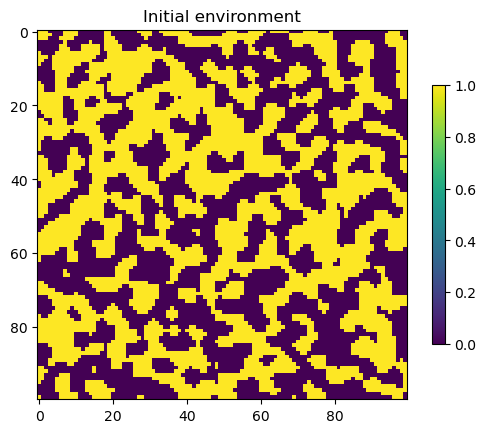

In [13]:
# Visualize Environment
fig = plt.figure()
plot = plt.imshow(lattice.env[..., 1])
plt.title("Initial environment")
fig.colorbar(plot, shrink=0.7)

In [14]:
# Run simulation
# A negative productivity threshold indicates that all cells are settled
lattice.set_search_params(prod_threshold=10, neigh_type="von_neumann", distance=15, search_intelligently=True)
lattice.set_evolution_params(env_mutation_rate=0.001, skill_mutation_rate=0.01, skill_mutates_randomly=False,
                             repopulate_empty_cells=True, metropolis_scale=10)

# Profile the code
profiler = cProfile.Profile()
profiler.enable()

lattice.run(disable_progress_bar=False, track_prod=True)

profiler.disable()

100%|██████████| 4999/4999 [01:35<00:00, 52.51it/s] 


In [15]:
# Print stats
stats = pstats.Stats(profiler)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

         12269278 function calls in 95.205 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   428018   49.079    0.000   49.079    0.000 {built-in method numpy.array}
   431514   17.888    0.000   81.393    0.000 C:\Users\leoko\AppData\Local\Temp\ipykernel_22840\3341058860.py:211(get_neighbors)
   433017    5.594    0.000   16.760    0.000 C:\Users\leoko\AppData\Local\Temp\ipykernel_22840\3998622134.py:19(calculate_productivity)
   944276    4.486    0.000    4.486    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   433017    3.744    0.000    3.744    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
     9998    2.488    0.000    4.585    0.000 C:\Users\leoko\AppData\Local\Temp\ipykernel_22840\3341058860.py:269(flip_single_entry_per_cell)
     4999    2.018    0.000    5.648    0.001 C:\Users\leoko\AppData\Local\Temp\ipykernel_22840\3341058860.py:147(mutate_skill_metropolis)
     4999    1.558    0.000   94

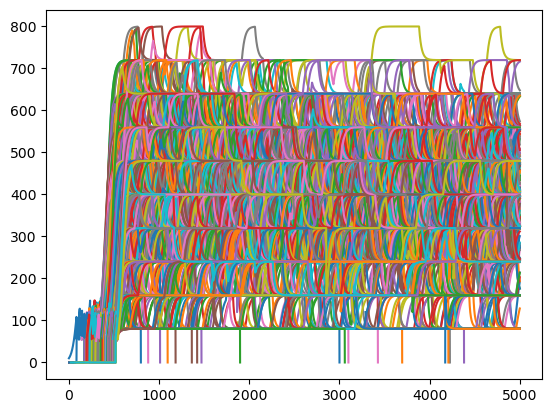

In [16]:
# Plot population of different cells
fig = plt.figure() # no NAN values

to_plot = lattice.population
for ii in range(10):
    plt.plot(to_plot[:, :, ii])

In [64]:
# As final: Compare different cases:
# A) No mutation B) Environment mutation C) Only skill mutation D) Environment + Skill mutation E) Environment + Skill metropolis

# Parameters
seed = 198
M = 100 # size of lattice (1D)
num_vars = 10 # length of envs vector)
p_0 = 800 # Basic productivity - sets the population limit for a cell where environment and skill perfectly match - prev. 800
pop_min, pop_max = 100, 200 # Min and max population for a village to split

# Updating the population dynamics
sim_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - denotes time

# p_min = 1 / (8 * num_vars) * p_0 # If None, population gets clipped to zero in each update of the logistic ODE
p_min = None

In [65]:
# No mutation
lattice_no_mutation = Lattice(size=M, steps_sim=sim_steps, seed=seed, idx_start=(0, 0), num_env_vars=num_vars,
                              pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Run simulation
# A negative productivity threshold indicates that all cells are settled
lattice_no_mutation.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
lattice_no_mutation.set_evolution_params(env_mutation_rate=None, skill_mutation_rate=None, skill_mutates_randomly=False,
                             repopulate_empty_cells=True, metropolis_scale=10)

lattice_no_mutation.run(disable_progress_bar=False, track_prod=True)

100%|██████████| 4999/4999 [04:46<00:00, 17.44it/s] 


In [66]:
# Env mutation
lattice_env_mutation = Lattice(size=M, steps_sim=sim_steps, seed=seed, idx_start=(0, 0), num_env_vars=num_vars,
                              pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Run simulation
# A negative productivity threshold indicates that all cells are settled
lattice_env_mutation.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
lattice_env_mutation.set_evolution_params(env_mutation_rate=0.01, skill_mutation_rate=None, skill_mutates_randomly=False,
                                        repopulate_empty_cells=True, metropolis_scale=10)

lattice_env_mutation.run(disable_progress_bar=False, track_prod=True)

 88%|████████▊ | 4419/4999 [09:59<01:18,  7.37it/s] 


KeyboardInterrupt: 

In [ ]:
# Skill only mutation - random
lattice_skill_mutation = Lattice(size=M, steps_sim=sim_steps, seed=seed, idx_start=(0, 0), num_env_vars=num_vars,
                              pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Run simulation
# A negative productivity threshold indicates that all cells are settled
lattice_skill_mutation.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
lattice_skill_mutation.set_evolution_params(env_mutation_rate=None, skill_mutation_rate=0.01, skill_mutates_randomly=True,
                                        repopulate_empty_cells=True, metropolis_scale=10)

lattice_skill_mutation.run(disable_progress_bar=False, track_prod=True)

In [ ]:
# Skill only mutation - Metropolis - slower than random which is sensible as productiviy must be calculated again
lattice_skill_metropolis = Lattice(size=M, steps_sim=sim_steps, seed=seed, idx_start=(0, 0), num_env_vars=num_vars,
                              pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Run simulation
# A negative productivity threshold indicates that all cells are settled
lattice_skill_metropolis.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
lattice_skill_metropolis.set_evolution_params(env_mutation_rate=None, skill_mutation_rate=0.01, skill_mutates_randomly=False,
                                        repopulate_empty_cells=True, metropolis_scale=10)

lattice_skill_metropolis.run(disable_progress_bar=False, track_prod=True)

In [ ]:
# Environment + skill mutation - random
# Skill only mutation - random
lattice_skill_env_mutation = Lattice(size=M, steps_sim=sim_steps, seed=seed, idx_start=(0, 0), num_env_vars=num_vars,
                              pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Run simulation
lattice_skill_env_mutation.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
lattice_skill_env_mutation.set_evolution_params(env_mutation_rate=0.001, skill_mutation_rate=0.01, skill_mutates_randomly=True, repopulate_empty_cells=True, metropolis_scale=10)

lattice_skill_env_mutation.run(disable_progress_bar=False, track_prod=True)

In [ ]:
# Environment + skill mutation - metropolis
# Skill only mutation - random
lattice_skill_env_metropolis = Lattice(size=M, steps_sim=sim_steps, seed=seed, idx_start=(0, 0), num_env_vars=num_vars,
                              pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Run simulation
lattice_skill_env_metropolis.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
lattice_skill_env_metropolis.set_evolution_params(env_mutation_rate=0.001, skill_mutation_rate=0.01, skill_mutates_randomly=False, repopulate_empty_cells=True, metropolis_scale=10)

lattice_skill_env_metropolis.run(disable_progress_bar=False, track_prod=True)

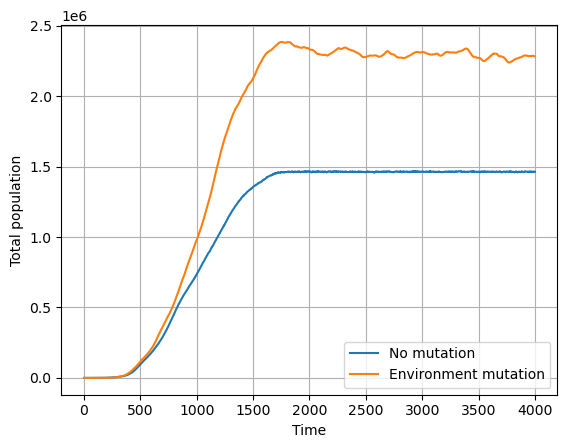

In [68]:
# Get populations
fig = plt.figure()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Total population")
lattices = [lattice_no_mutation, lattice_env_mutation, lattice_skill_mutation, lattice_skill_env_mutation,
            lattice_skill_metropolis, lattice_skill_env_metropolis]

labels = ["No mutation", "Environment mutation", "Skill mutation random", "Env + Skill random",
          "Skill mutation metropolis", "Env + Skill Metropolis"]

for ll, label in zip(lattices[:2], labels[:2]):
    villagers = ll.population
    villagers[np.isnan(villagers)] = 0
    villagers = np.sum(villagers, axis=(1, 2))
    plt.plot(villagers[:4000], label=label)

plt.legend()

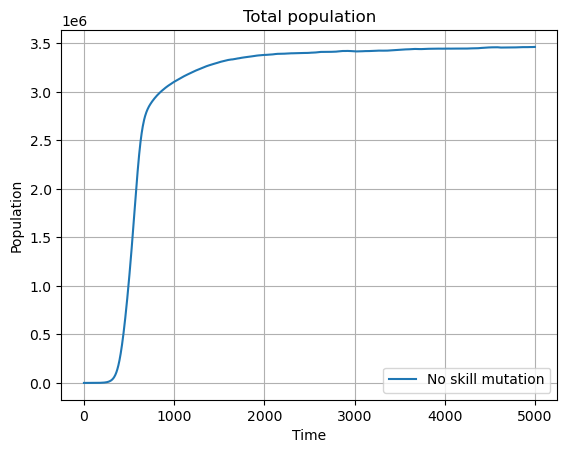

In [17]:
# Get entire population
fig = plt.figure()

pop_t = lattice.population

pop_t[np.isnan(pop_t)] = 0 # to clean for NaN values
pop_total = np.sum(pop_t, axis=(1, 2))

plt.plot(pop_total[:-1], label="No skill mutation")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")
plt.legend()

In [26]:
# average skill vector for lattice - shape is (steps, h, w, skills)
skill_analyze = lattice.skill_full
skill_avg = np.mean(skill_analyze, axis=3)
print(skill_avg.shape)

(10000, 100, 100)


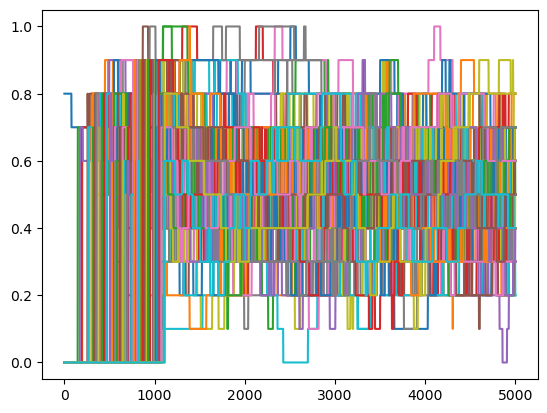

In [27]:
plt.plot(skill_avg[:5000, 0, :])

In [38]:
# Run for multiple simulations
populations_to_plot = []

for ii, ll in tqdm(enumerate(lattice_diff_seeds), leave=True, desc="Loop"):
    # Set parameters
    ll.set_search_params(prod_threshold=-1, neigh_type="von_neumann", distance=5, search_intelligently=False)
    ll.set_evolution_params(env_mutation_rate=0.001, skill_mutation_rate=0.5, skill_mutates_randomly=False)

    ll.run(disable_progress_bar=True, track_prod=False)
    pop_ll = ll.population
    pop_ll[np.isnan(pop_ll)] = 0
    pop_ll = np.sum(pop_ll, axis=(1, 2))
    populations_to_plot.append(pop_ll)

# Normalize and plot
# populations_to_plot = np.array(populations_to_plot)
# populations_to_plot = populations_to_plot / np.amax(populations_to_plot)

Loop: 10it [03:48, 22.82s/it]


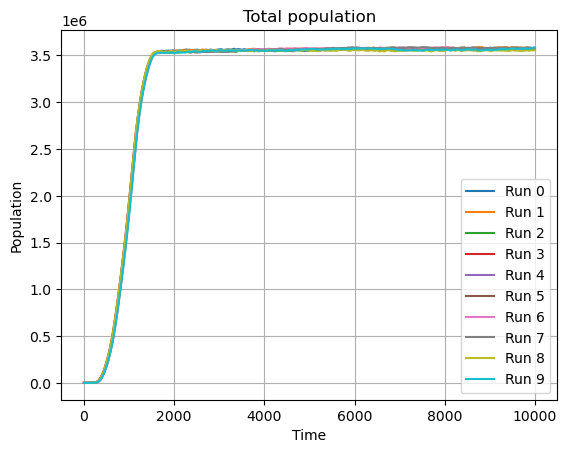

In [39]:
fig = plt.figure()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")

for ii, entry in enumerate(populations_to_plot):
    plt.plot(entry, label=f"Run {ii}")

plt.legend()

[1. 0. 1. 1. 0. 0. 0. 1. 0. 1.]


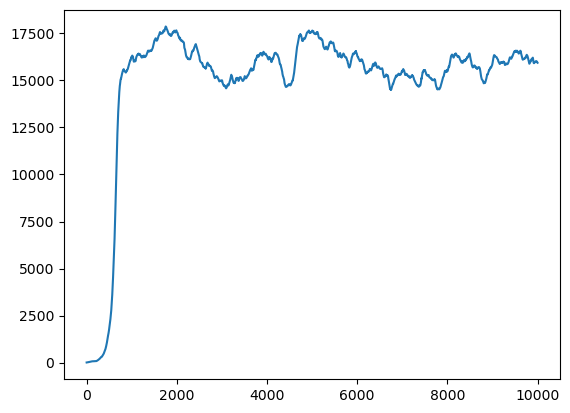

In [16]:
# plt.plot(populations_to_plot[9])

ll_test = lattice_diff_seeds[9]

print(ll_test.skills[0, 0])

ll_test_prod = ll_test.population

# print(ll_test_prod[10, :, :])

ll_test_sum = np.sum(ll_test_prod, axis=(1, 2))

plt.plot(ll_test_sum)

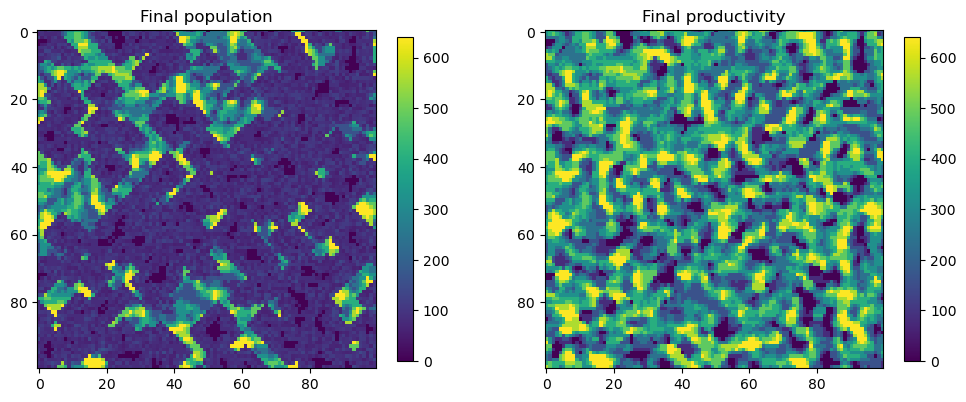

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.population[-1, :, :])
ax1.set_title("Final population")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(lattice.prod)
ax2.set_title("Final productivity")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

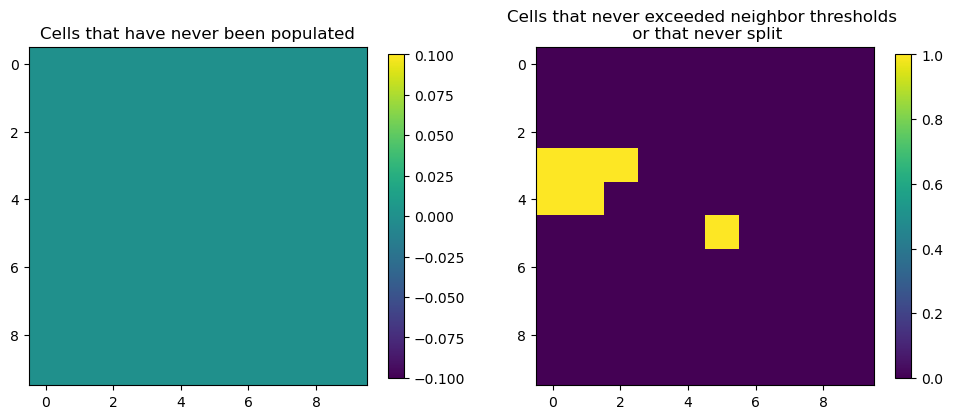

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.is_empty)
ax1.set_title("Cells that have never been populated")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(lattice.has_empty_neighbors)
ax2.set_title("Cells that never exceeded neighbor thresholds \n or that never split")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

In [ ]:
# A cell that never exceeds neighbor thresholds means that this cell either hasn't split often enough (because there productivity is so low), or
# perhaps the name has no empty neighbors is misleading